In [101]:
import pandas as pd
import numpy as np
import os

import pandas as pd
import numpy as np
import os

from itertools import combinations

import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import io
import base64
import scipy.stats as stats

from itertools import combinations

from scipy.stats import shapiro, levene, ttest_ind
from joypy import joyplot

In [102]:
import seaborn as sns
print(sns.__version__)


0.13.2


In [103]:
null_values = {'N.A': np.nan, 'N': np.nan, 'N.A.': np.nan, "N,A": np.nan, 'N.A.': np.nan, 'N.A ': np.nan}

In [104]:
carpeta = "data_raw" #"data_raw"

# Lista para guardar todos los DataFrames leídos
list_dataframe = []

for archivo in os.listdir(carpeta):
    if "pellet" in archivo.lower() and archivo.lower().endswith('.xlsx'):
        ruta_completa = os.path.join(carpeta, archivo)
        
        try:
            # Leer el archivo como CSV con pandas
            df = pd.read_excel(ruta_completa, skiprows=10)
            cond = df["Fecha Prod."].notnull()
            df = df[cond]
            list_dataframe.append(df)
            print(f"Leído: {archivo} - Filas: {len(df)}")
        except Exception as e:
            print(f"Error leyendo {archivo}: {e}")

dataframes = pd.concat(list_dataframe)

Leído: SIG-FT-409 Control proceso Pellet y molienda Planta de alimentos balanceados V4 - Febrero 2025.xlsx - Filas: 280
Leído: SIG-FT-409 Control proceso Pellet y molienda Planta de alimentos balanceados V4 - diciembre 2024.xlsx - Filas: 135
Leído: SIG-FT-409 Control proceso Pellet y molienda Planta de alimentos balanceados V4 - Enero 2025.xlsx - Filas: 267
Leído: SIG-FT-409 Control proceso Pellet y molienda Planta de alimentos balanceados V4 - Noviembre 2024.xlsx - Filas: 48


In [105]:

nov = pd.read_excel("data_raw/SIG-FT-411 Control proceso Temperaturas Planta de alimentos balanceados V2 (2).xlsx", sheet_name="NOVIEMBRE", skiprows=3)
dic = pd.read_excel("data_raw/SIG-FT-411 Control proceso Temperaturas Planta de alimentos balanceados V2 (3).xlsx", sheet_name="DICIEMBRE ", skiprows=3)
feb = pd.read_excel("data_raw/SIG-FT-411 Control proceso Temperaturas Planta de alimentos balanceados V2 (1).xlsx", sheet_name="FEBRERO", skiprows=3)
ene = pd.read_excel("data_raw/SIG-FT-411 Control proceso Temperaturas Planta de alimentos balanceados V2.xlsx", sheet_name="ENERO ", skiprows=3)

nov["dif1"] = nov["FECHA TOMA DE MUESTRA"].shift(1)
nov.loc[nov["SITIO TOMA DE MUESTRA"] == "PELLET 1", "FECHA TOMA DE MUESTRA"] = nov["dif1"]

dic["dif1"] = dic["FECHA TOMA DE MUESTRA"].shift(1)
dic.loc[dic["SITIO TOMA DE MUESTRA"] == "PELLET 1", "FECHA TOMA DE MUESTRA"] = dic["dif1"]

ene["dif1"] = ene["FECHA TOMA DE MUESTRA"].shift(1)
ene.loc[ene["SITIO TOMA DE MUESTRA"] == "PELLET 1", "FECHA TOMA DE MUESTRA"] = ene["dif1"]

feb["dif1"] = feb["FECHA TOMA DE MUESTRA"].shift(1)
feb.loc[feb["SITIO TOMA DE MUESTRA"] == "PELLET 1", "FECHA TOMA DE MUESTRA"] = feb["dif1"]



nov["dif1"] = nov["HORA"].shift(1)
nov.loc[nov["SITIO TOMA DE MUESTRA"] == "PELLET 1", "HORA"] = nov["dif1"]

dic["dif1"] = dic["HORA"].shift(1)
dic.loc[dic["SITIO TOMA DE MUESTRA"] == "PELLET 1", "HORA"] = dic["dif1"]

ene["dif1"] = ene["HORA"].shift(1)
ene.loc[ene["SITIO TOMA DE MUESTRA"] == "PELLET 1", "HORA"] = ene["dif1"]

feb["dif1"] = feb["HORA"].shift(1)
feb.loc[feb["SITIO TOMA DE MUESTRA"] == "PELLET 1", "HORA"] = feb["dif1"]

temp = pd.concat([nov, dic, feb, ene])
temp = temp.reset_index()
temp = temp.replace(null_values)
temp["FORMULACION"] = temp["FORMULACION"].str.strip()

temp["SITIO TOMA DE MUESTRA"].value_counts()

/var/folders/1g/77kw2x4j5678s_87_sqc1fpc0000gp/T/ipykernel_78478/2329287483.py:34: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  temp = temp.replace(null_values)


SITIO TOMA DE MUESTRA
ACONDICIONADOR 1    90
PELLET 1            90
ENFRIADORA 1        90
Name: count, dtype: int64

In [106]:
cond1 = temp["SITIO TOMA DE MUESTRA"] == "PELLET 1"
cond2 = temp["TERMOMETRO AGROINDUSTRIA"].notnull()
temp_pellet = temp[cond1 & cond2]

cond1 = temp["SITIO TOMA DE MUESTRA"] == "ACONDICIONADOR 1"
cond3 = temp["TERMOMETRO AGROINDUSTRIA"].notnull()
temp_acond = temp[cond1 & (cond2 | cond3)]

cond1 = temp["SITIO TOMA DE MUESTRA"] == "ENFRIADORA 1"
temp_enf = temp[cond1 & (cond2 | cond3)]

In [107]:

dataframes["Fecha Prod."] = dataframes["Fecha Prod."].replace({"12/01/202": '2024-12-01', "10/02/202": "2024-10-02"})
dataframes[dataframes["Fecha Prod."] == '12/01/202']
dataframes["Fecha"] = pd.to_datetime(dataframes["Fecha Prod."], errors="ignore", infer_datetime_format=True).dt.date

dataframes = dataframes[dataframes["Punto"].notnull()]
dataframes["Muestra"] = dataframes["Muestra"].str.strip()
dataframes["Punto"] = dataframes["Punto"].str.strip()
dataframes["Producto"] = dataframes["Producto"].str.strip()

/var/folders/1g/77kw2x4j5678s_87_sqc1fpc0000gp/T/ipykernel_78478/152241821.py:3: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  dataframes["Fecha"] = pd.to_datetime(dataframes["Fecha Prod."], errors="ignore", infer_datetime_format=True).dt.date
/var/folders/1g/77kw2x4j5678s_87_sqc1fpc0000gp/T/ipykernel_78478/152241821.py:3: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  dataframes["Fecha"] = pd.to_datetime(dataframes["Fecha Prod."], errors="ignore", infer_datetime_format=True).dt.date


In [108]:
df_group = dataframes.groupby("OP", as_index=False).agg({"Código": "unique"})

# Contar la cantidad de elementos en cada lista
df_group["Código len"] = df_group["Código"].apply(len)
df_group_ops = df_group[df_group["Código len"]>1]
df_group_ops

,OP,Código,Código len
0,1.0,"[200541.0, 2513.0, 2506.0, 200544.0]",4
15,18.0,"[200542.0, 200541.0]",2
24,27.0,"[200542.0, 200544.0]",2
27,30.0,"[200543.0, 200541.0]",2


In [109]:
df_group = dataframes.groupby(["OP", "Fecha"],as_index=False).agg({"Código": "unique"})#.head(40) "Fecha"
df_group = df_group[df_group["OP"].isin(df_group_ops["OP"])]
#df_group["Código len"] = df_group["Código"].apply(len)
df_group["Código"] = df_group["Código"].astype('str')
#df_group["Código len"] = df_group["Código"].apply(lambda x: len(x))
df_group = df_group.drop_duplicates(["OP", "Código"])
#df_group_ops = df_group[df_group["Código len"]>1]
df_group
modo_por_grupo = dataframes.groupby("OP")["Código"].apply(lambda x: x.mode().iloc[0] if not x.mode().empty else None).reset_index()
modo_por_grupo.rename(columns={"Código": "Código_que_mas_se_repite"}, inplace=True)
df_group_bad = pd.merge(df_group, modo_por_grupo, on='OP', how="left")
df_group_bad

,OP,Fecha,Código,Código_que_mas_se_repite
0,1.0,2024-11-15,[200541.],200541.0
1,1.0,2024-11-21,[2513. 2506.],200541.0
2,1.0,2024-11-23,[ 2513. 200544.],200541.0
3,1.0,2024-11-25,[200544.],200541.0
4,18.0,2024-12-21,[200542.],200542.0
5,18.0,2025-01-27,[200541.],200542.0
6,27.0,2024-12-26,[200542.],200542.0
7,27.0,2025-01-05,[200544.],200542.0
8,30.0,2024-12-27,[200543.],200543.0
9,30.0,2025-01-29,[200541.],200543.0


In [110]:
ops_good = df_group_bad[["OP", "Código_que_mas_se_repite"]]
ops_good = ops_good.drop_duplicates()


dataframes = pd.merge(dataframes, ops_good, on="OP", how="left")
dataframes.loc[dataframes["Código_que_mas_se_repite"].notnull(), "Código"] = dataframes["Código_que_mas_se_repite"]

In [112]:
dataframes["Código"].value_counts()

Código
200541.0    288
200542.0    151
200544.0    133
200543.0     60
200107.0     41
200120.0     24
200119.0     18
200106.0     14
Name: count, dtype: int64

In [113]:
dataframes.groupby(["Producto"]).agg({"Código":"unique"})

,Código
Producto,
C. ENGORDE ESP P.,[200120.0]
C. FINALIZADOR P.,[200119.0]
C. LEVANTE ESP. P,[200106.0]
C. LEVANTE P.,[200107.0]
C. LEVANTE VR P.,"[200541.0, 200542.0, 200543.0]"
C.ENGORDE ESP VR.,[200543.0]
C.FINALIZADOR P.,[200541.0]
C.FINALIZADOR VR P.,"[200544.0, 200542.0]"
C.LEVANTE P.,[200541.0]


In [115]:
dataframes.groupby(["Código"], as_index=False).agg({"Producto":"unique"})

,Código,Producto
0,200106.0,[C. LEVANTE ESP. P]
1,200107.0,[C. LEVANTE P.]
2,200119.0,[C. FINALIZADOR P.]
3,200120.0,[C. ENGORDE ESP P.]
4,200541.0,"[C. LEVANTE VR P., C.FINALIZADOR P., C.LEVANTE..."
5,200542.0,"[LEVANTE R ESP VR, C.FINALIZADOR VR P., C. LEV..."
6,200543.0,"[C.ENGORDE ESP VR., C. LEVANTE VR P.]"
7,200544.0,"[FINALIZADOR VR., C.FINALIZADOR VR P.]"


In [119]:
dataframes.groupby(["Código", "Producto"], as_index=False).agg({"Fecha":"count"}).sort_values("Producto")

,Código,Producto,Fecha
3,200120.0,C. ENGORDE ESP P.,24
2,200119.0,C. FINALIZADOR P.,18
0,200106.0,C. LEVANTE ESP. P,14
1,200107.0,C. LEVANTE P.,41
4,200541.0,C. LEVANTE VR P.,267
8,200542.0,C. LEVANTE VR P.,1
11,200543.0,C. LEVANTE VR P.,1
12,200543.0,C.ENGORDE ESP VR.,59
5,200541.0,C.FINALIZADOR P.,9
9,200542.0,C.FINALIZADOR VR P.,1


In [120]:
dataframes["Código"].value_counts()

Código
200541.0    288
200542.0    151
200544.0    133
200543.0     60
200107.0     41
200120.0     24
200119.0     18
200106.0     14
Name: count, dtype: int64

In [121]:
dataframes["Producto"].value_counts()

Producto
C. LEVANTE VR P.       269
LEVANTE R ESP VR       149
FINALIZADOR VR.        136
C.ENGORDE ESP VR.       59
C. LEVANTE P.           41
C. ENGORDE ESP P.       24
C. FINALIZADOR P.       18
C. LEVANTE ESP. P       14
C.FINALIZADOR P.         9
C.FINALIZADOR VR P.      8
C.LEVANTE P.             2
Name: count, dtype: int64

In [122]:
dataframes["Producto"].unique()

array(['C. LEVANTE VR P.', 'FINALIZADOR VR.', 'C.ENGORDE ESP VR.',
       'LEVANTE R ESP VR', 'C. FINALIZADOR P.', 'C. LEVANTE P.',
       'C. ENGORDE ESP P.', 'C. LEVANTE ESP. P', 'C.FINALIZADOR VR P.',
       'C.FINALIZADOR P.', 'C.LEVANTE P.'], dtype=object)

In [124]:
replace_name = {
'C. LEVANTE P.':'C.LEVANTE P.',
'C.FINALIZADOR VR P.':'FINALIZADOR VR.',
'C.FINALIZADOR P.':'FINALIZADOR VR.',

#'C.LEVANTE ESP VR': 'LEVANTE ESP VR',
#'C.FINALIZACION VR': 'FINALIZADOR VR.',
#'C.LEVANTE  VR': 'LEVANTE VR',
}

dataframes["Producto"] = dataframes["Producto"].replace(replace_name)

In [125]:
temp["FORMULACION"].value_counts()

FORMULACION
LEVANTE VR           54
FINAL VR             30
LEVANTE ESP VR       24
FINALIZADOR VR.      18
FINALIZADOR VR       15
ENGORDE ESP VR       12
C.LEVANTE  VR         9
C.FINALIZACION VR     9
C.LEVANTE ESP VR      6
LEVANTE               6
ENGORDE ESP           6
Name: count, dtype: int64

In [126]:
dataframes[dataframes["OP"] == 30][["Código", "Producto"]]

,Código,Producto
389,200543.0,C.ENGORDE ESP VR.
390,200543.0,C.ENGORDE ESP VR.
653,200543.0,C. LEVANTE VR P.


In [127]:
dataframes.groupby(["Producto"]).agg({"Código":"unique"})

,Código
Producto,
C. ENGORDE ESP P.,[200120.0]
C. FINALIZADOR P.,[200119.0]
C. LEVANTE ESP. P,[200106.0]
C. LEVANTE VR P.,"[200541.0, 200542.0, 200543.0]"
C.ENGORDE ESP VR.,[200543.0]
C.LEVANTE P.,"[200107.0, 200541.0]"
FINALIZADOR VR.,"[200544.0, 200542.0, 200541.0]"
LEVANTE R ESP VR,[200542.0]


In [128]:
temp.groupby(["FORMULACION"]).agg({"CÓDIGO": "unique"})

,CÓDIGO
FORMULACION,
C.FINALIZACION VR,[200544.0]
C.LEVANTE VR,[200541.0]
C.LEVANTE ESP VR,[200542.0]
ENGORDE ESP,[200120.0]
ENGORDE ESP VR,[200543.0]
FINAL VR,"[200544.0, 200119.0]"
FINALIZADOR VR,[200544.0]
FINALIZADOR VR.,[200544.0]
LEVANTE,[200107.0]


In [129]:
dataframes.groupby(["Producto"]).agg({"Código":"unique"})

,Código
Producto,
C. ENGORDE ESP P.,[200120.0]
C. FINALIZADOR P.,[200119.0]
C. LEVANTE ESP. P,[200106.0]
C. LEVANTE VR P.,"[200541.0, 200542.0, 200543.0]"
C.ENGORDE ESP VR.,[200543.0]
C.LEVANTE P.,"[200107.0, 200541.0]"
FINALIZADOR VR.,"[200544.0, 200542.0, 200541.0]"
LEVANTE R ESP VR,[200542.0]


In [130]:
dataframes.groupby(["Código"]).agg({"Producto":["unique", "count"]})


Producto      
                                                     unique count
Código                                                           
200106.0                                [C. LEVANTE ESP. P]    14
200107.0                                     [C.LEVANTE P.]    41
200119.0                                [C. FINALIZADOR P.]    18
200120.0                                [C. ENGORDE ESP P.]    24
200541.0  [C. LEVANTE VR P., FINALIZADOR VR., C.LEVANTE P.]   288
200542.0  [LEVANTE R ESP VR, FINALIZADOR VR., C. LEVANTE...   151
200543.0              [C.ENGORDE ESP VR., C. LEVANTE VR P.]    60
200544.0                                  [FINALIZADOR VR.]   133

In [131]:
temp.groupby(["CÓDIGO"]).agg({"FORMULACION":["unique", "count"]})

FORMULACION      
                                                     unique count
CÓDIGO                                                           
200107.0                                          [LEVANTE]     6
200119.0                                         [FINAL VR]     6
200120.0                                      [ENGORDE ESP]     6
200541.0                        [LEVANTE VR, C.LEVANTE  VR]    63
200542.0                 [C.LEVANTE ESP VR, LEVANTE ESP VR]    30
200543.0                                   [ENGORDE ESP VR]    12
200544.0  [FINALIZADOR VR., C.FINALIZACION VR, FINAL VR,...    66

In [132]:
temp["FORMULACION"].value_counts()

FORMULACION
LEVANTE VR           54
FINAL VR             30
LEVANTE ESP VR       24
FINALIZADOR VR.      18
FINALIZADOR VR       15
ENGORDE ESP VR       12
C.LEVANTE  VR         9
C.FINALIZACION VR     9
C.LEVANTE ESP VR      6
LEVANTE               6
ENGORDE ESP           6
Name: count, dtype: int64

In [133]:
temp["CÓDIGO"].value_counts()

CÓDIGO
200544.0    66
200541.0    63
200542.0    30
200543.0    12
200119.0     6
200107.0     6
200120.0     6
Name: count, dtype: int64

In [134]:
temp.groupby(["CÓDIGO"]).agg({"FORMULACION":["unique", "count"]})

FORMULACION      
                                                     unique count
CÓDIGO                                                           
200107.0                                          [LEVANTE]     6
200119.0                                         [FINAL VR]     6
200120.0                                      [ENGORDE ESP]     6
200541.0                        [LEVANTE VR, C.LEVANTE  VR]    63
200542.0                 [C.LEVANTE ESP VR, LEVANTE ESP VR]    30
200543.0                                   [ENGORDE ESP VR]    12
200544.0  [FINALIZADOR VR., C.FINALIZACION VR, FINAL VR,...    66

In [135]:
temp.groupby(["FORMULACION"]).agg({"CÓDIGO":["unique", "count"]})

CÓDIGO      
                                 unique count
FORMULACION                                  
C.FINALIZACION VR            [200544.0]     9
C.LEVANTE  VR                [200541.0]     9
C.LEVANTE ESP VR             [200542.0]     6
ENGORDE ESP                  [200120.0]     6
ENGORDE ESP VR               [200543.0]    12
FINAL VR           [200544.0, 200119.0]    30
FINALIZADOR VR               [200544.0]    15
FINALIZADOR VR.              [200544.0]    18
LEVANTE                      [200107.0]     6
LEVANTE ESP VR               [200542.0]    24
LEVANTE VR                   [200541.0]    54

In [136]:

temp_rename = {
    "FINALIZADOR VR.": "FINALIZADOR VR.", 
    "FINALIZADOR VR": "FINALIZADOR VR.",
    'FINAL VR': "FINALIZADOR VR.",
    "C.FINALIZACION VR": "FINALIZADOR VR.",
    'C. LEVANTE P.': "C.LEVANTE P.",
    'C.LEVANTE VR': 'LEVANTE VR',
    'C.LEVANTE ESP VR': 'LEVANTE ESP VR'
    }

#temp["Dieta"] = temp["Dieta"].replace(temp_rename)

In [137]:
#temp["Dieta"].unique()

In [138]:
#cod_name = pd.read_csv("cod_name.csv")
#dataframes = pd.merge(dataframes, cod_name, on='Código', how='left')

In [139]:
dataframes.groupby(["Producto"]).agg({"Código":"unique"})

,Código
Producto,
C. ENGORDE ESP P.,[200120.0]
C. FINALIZADOR P.,[200119.0]
C. LEVANTE ESP. P,[200106.0]
C. LEVANTE VR P.,"[200541.0, 200542.0, 200543.0]"
C.ENGORDE ESP VR.,[200543.0]
C.LEVANTE P.,"[200107.0, 200541.0]"
FINALIZADOR VR.,"[200544.0, 200542.0, 200541.0]"
LEVANTE R ESP VR,[200542.0]


In [140]:
dataframes.groupby(["Código"]).agg({"Producto":["unique", "count"]})


Producto      
                                                     unique count
Código                                                           
200106.0                                [C. LEVANTE ESP. P]    14
200107.0                                     [C.LEVANTE P.]    41
200119.0                                [C. FINALIZADOR P.]    18
200120.0                                [C. ENGORDE ESP P.]    24
200541.0  [C. LEVANTE VR P., FINALIZADOR VR., C.LEVANTE P.]   288
200542.0  [LEVANTE R ESP VR, FINALIZADOR VR., C. LEVANTE...   151
200543.0              [C.ENGORDE ESP VR., C. LEVANTE VR P.]    60
200544.0                                  [FINALIZADOR VR.]   133

In [142]:
dataframes = dataframes.replace(null_values)

In [143]:
rename = {

'% Durab.' : "Porcentaje Durabilidad",
' Dureza kg/cm²': "Dureza",
'10,00': "Malla 10%",
'12,00': "Malla 12%",
'14,00':  "Malla 14%", 
'16,00':  "Malla 16%",
'PAN':  "Pan",
'ANALISTA ': "Analista",
'Producto': "Dieta",
"OP": "Orden producción",
'SITIO TOMA DE MUESTRA': "Punto",
'CÓDIGO': "Código", 
'FORMULACION': "Dieta",
}
df_filter = dataframes.rename(columns=rename)
temp = temp.rename(columns=rename)

In [144]:
temp.columns

Index(['index', 'FECHA TOMA DE MUESTRA', 'HORA', 'TURNO', 'Punto',
       'TERMOMETRO PLANTA', 'TERMOMETRO AGROINDUSTRIA', 'Código', 'Dieta',
       'Orden producción', 'RESPONSABLE', 'OBSERVACIONES', 'dif1'],
      dtype='object')

In [145]:
df_filter['Dieta agrupada'] = df_filter.loc[:, 'Dieta']
df_filter['Dieta agrupada'] = df_filter['Dieta agrupada'].str.replace(r'(?i).*FIN.*', 'FINALIZADOR', regex=True)
df_filter['Dieta agrupada'] = df_filter['Dieta agrupada'].str.replace(r'(?i).*LEV.*', 'LEVANTE', regex=True)
df_filter['Dieta agrupada'] = df_filter['Dieta agrupada'].str.replace(r'(?i).*ENG.*', 'ENGORDE', regex=True)

cond_pellet_meansurement = (df_filter["m1"].notnull())
df_filter.loc[cond_pellet_meansurement, "Muestra"] = "PELLET"

cond_molienda_meansurement = (df_filter["Malla 12%"].notnull())
df_filter.loc[cond_molienda_meansurement, "Muestra"] = "MOLIENDA"


cond_molienda = df_filter["Muestra"] == "MOLIENDA"
df_filter.loc[cond_molienda, "Punto"] = "TOLVA"

cond_pellet = df_filter["Muestra"] == "PELLET"
cond_tolva= df_filter["Punto"] == "TOLVA"
df_filter.loc[cond_pellet & cond_tolva, "Punto"] = "ZARANDA 1"

In [152]:
def build_group(group_, agg_, df):
    agg = dict(
    Media=(agg_, "mean"),
    Mínimo=(agg_, "min"), 
    P25=(agg_, lambda x: x.quantile(0.25)),
    Mediana=(agg_, "median"),
    P75=(agg_, lambda x: x.quantile(0.75)),
    Máximo=(agg_, "max"),
    Cantidad=(agg_, "count"),
    Desviacion_Estandar=(agg_, "std"),  # Dispersión
    Varianza=(agg_, "var"),             # Varianza
    Error_Estandar=(agg_, lambda x: x.std() / (len(x) ** 0.5))  # Error estándar de la media

    )

    df_filter_group = df.groupby(group_, as_index=False).agg(**agg)

    # Iterar sobre las columnas y redondear a dos decimales si son numéricas
    for col in df_filter_group.columns:
        if pd.api.types.is_numeric_dtype(df_filter_group[col]):
            df_filter_group[col] = df_filter_group[col].round(2)
    rename = {"Desviacion_Estandar": "Desviación estandar", "Error_Estandar": "Error estandar"}
    df_filter_group = df_filter_group.rename(columns=rename)
    
    return df_filter_group


In [153]:
df_filter_pellet = df_filter[df_filter["Muestra"] == "PELLET"]
df_filter_pellet = df_filter_pellet.reset_index()
df_filter_molienda = df_filter[df_filter["Muestra"] == "MOLIENDA"]
df_filter_molienda = df_filter_molienda.reset_index()

df_filter_pellet = df_filter_pellet[df_filter_pellet["Punto"].isin(["ZARANDA 1", "POS-ENGRASE"])]

In [154]:
def build_stadistic(df, metrics, group_, name_group,  name_file,):

   
    df[metrics] = df[metrics].apply(pd.to_numeric, errors='coerce')
    df_ = df.reset_index(drop=True)

    grad_list = []  
    for col in metrics:
        group = build_group(group_=group_, agg_=col, df=df_)
        group[name_group] = col
        grad_list.append(group)

    # Concatenar todos los DataFrames en uno solo
    grad = pd.concat(grad_list).reset_index(drop=True)

    order_col = [name_group] + group_ +["Media", "Cantidad","Mínimo", "P25", "Mediana", "P75",
                "Máximo", "Desviación estandar", "Varianza",  "Error estandar"]

    grad = grad.loc[:, order_col]
    grad = grad[grad["Cantidad"] > 5] #TODO: cual seria un limite adecuado
    grad.to_csv(f"../data/estadisticos_{name_file}.csv", index=False)

    return grad

In [171]:

df = df_filter_molienda[["Dieta", 'Malla 10%']]
#m10.to_csv("m10.csv", index=False)
df['Malla 10%'] = df['Malla 10%'].apply(pd.to_numeric, errors='coerce')

/var/folders/1g/77kw2x4j5678s_87_sqc1fpc0000gp/T/ipykernel_78478/4138565838.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Malla 10%'] = df['Malla 10%'].apply(pd.to_numeric, errors='coerce')


In [217]:
order = [
    'LEVANTE R ESP VR',
    'C.LEVANTE P.',
    'C. LEVANTE ESP. P',
    'C. LEVANTE VR P.',
    'C. ENGORDE ESP P.',
    'C.ENGORDE ESP VR.',
    'C. FINALIZADOR P.',
    'FINALIZADOR VR.' ]

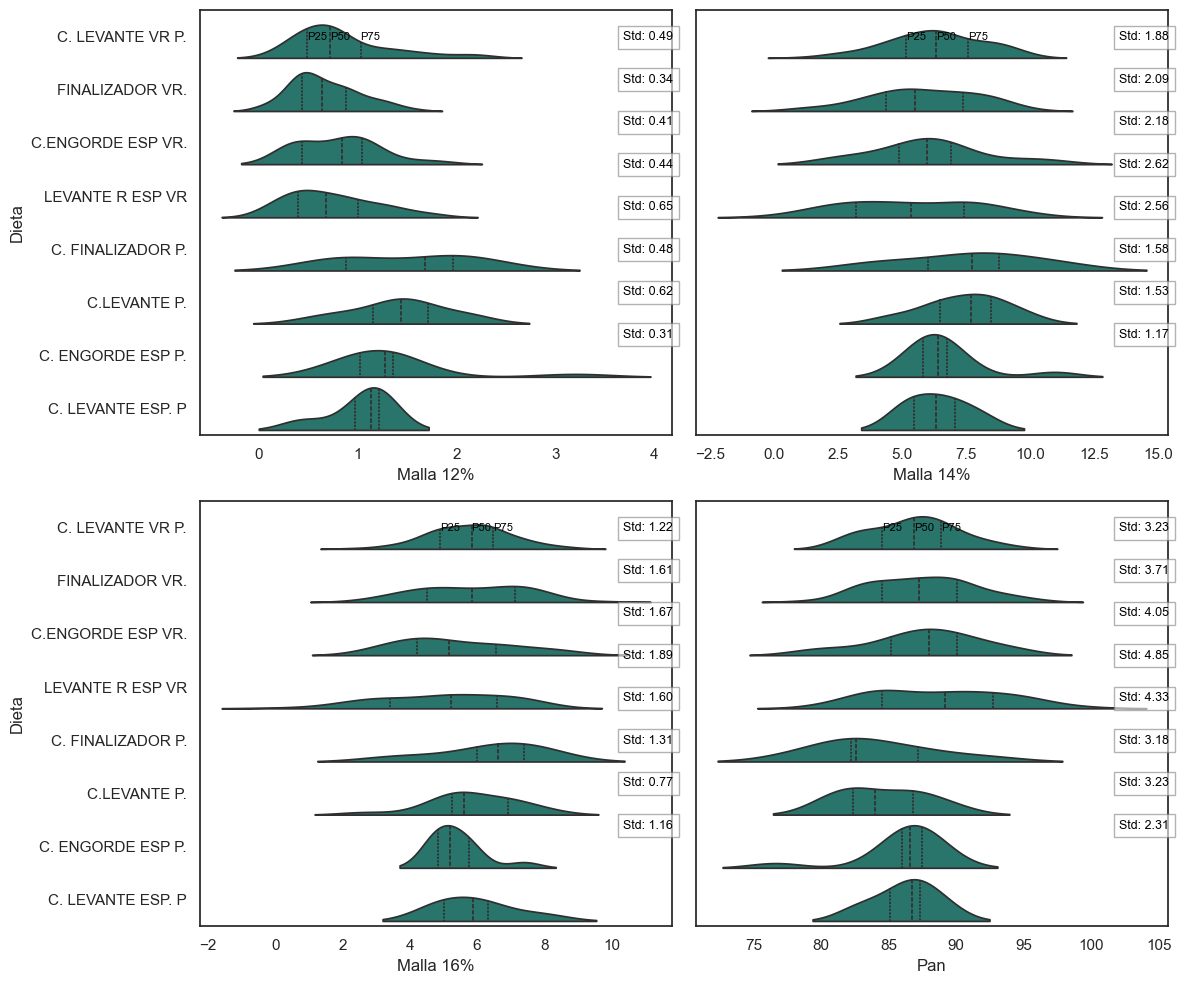

In [ ]:


# Lista de variables y títulos para cada subplot
variables = ["Malla 12%", "Malla 14%", "Malla 16%", "Pan"]
titles = ["Malla 12%", "Malla 14%", "Malla 16%", "Pan"]

# Crear la figura con subplots 2x2 que comparten el eje y
fig, axs = plt.subplots(2, 2, figsize=(12, 10), sharey=True)

# Recorrer cada eje y variable para trazar los gráficos
for ax, var, title in zip(axs.flat, variables, titles):
    # Gráfico de violín
    sns.violinplot(data=df_filter_molienda, y="Dieta", x=var, inner='quartile', split=True,
                   #order=order,
                   ax=ax, color="#1c8074")
    
    # Calcular y mostrar los percentiles para cada categoría en 'Dieta agrupada'
    categorias = df_filter_molienda["Dieta"].unique()
    for i, categoria in enumerate(categorias):
        # Obtener datos por categoría
        datos_categoria = df_filter_molienda[df_filter_molienda["Dieta"] == categoria][var].dropna()
        # Calcular desviación estándar
        std_dev = np.std(datos_categoria, ddof=1)  # ddof=1 para muestra
        ax.text(0.95, 0.95 - i * 0.1, f"Std: {std_dev:.2f}", 
                transform=ax.transAxes, 
                fontsize=9, color='black', 
                ha='center', va='top',
                #
                bbox=dict(facecolor='white', alpha=0.6, edgecolor='gray')
                )
        


        if categoria=='C. LEVANTE VR P.':
        
            # Calcular percentiles
            percentiles = np.percentile(datos_categoria, [25, 50, 75])

            
            # Colocar los nombres en una posición personalizada (esquina superior derecha)
            for p, label in zip(percentiles, ['P25', 'P50', 'P75']):
                ax.text(p, i, label, 
                        #ha='left',
                          va='center', 
                        fontsize=8, color='black',
                        #bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray')
                        )
    
   
plt.tight_layout()

# Guardar la imagen antes de mostrarla
plt.savefig("../images/granulometria_violin_plots.png", dpi=300)

# Mostrar la imagen en pantalla
plt.show()

# Cerrar la figura para liberar memoria
plt.close()


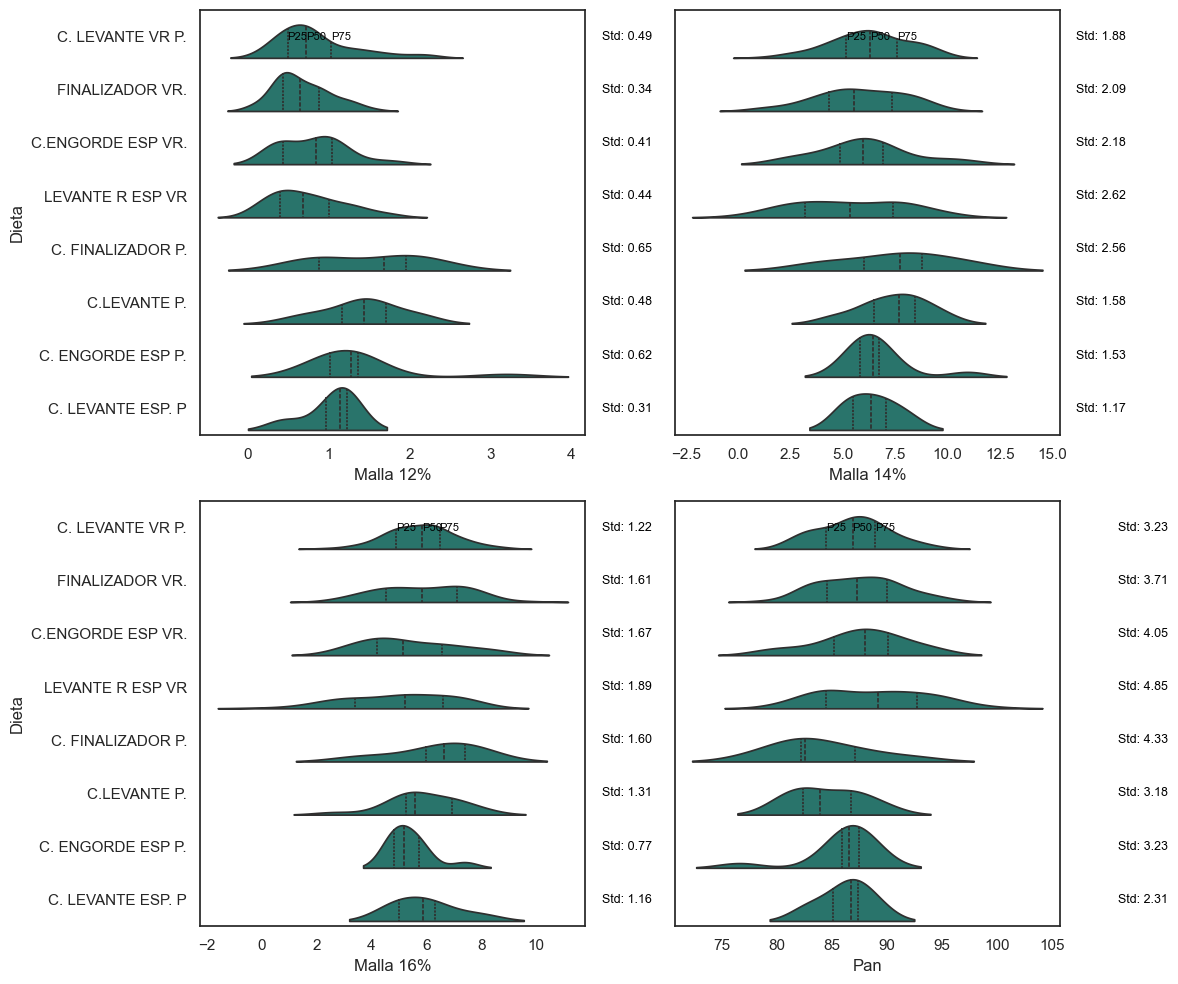

In [277]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Lista de variables y títulos para cada subplot
variables = ["Malla 12%", "Malla 14%", "Malla 16%", "Pan"]
titles = ["Malla 12%", "Malla 14%", "Malla 16%", "Pan"]

# Crear la figura con subplots 2x2 que comparten el eje y
fig, axs = plt.subplots(2, 2, figsize=(12, 10), sharey=True)

# Recorrer cada eje y variable para trazar los gráficos
for ax, var, title in zip(axs.flat, variables, titles):
    # Gráfico de violín
    sns.violinplot(data=df_filter_molienda, y="Dieta", x=var, inner='quartile', split=True,
                   ax=ax, color="#1c8074")
    
    # Calcular y mostrar los percentiles y desviación estándar para cada categoría en 'Dieta'
    categorias = df_filter_molienda["Dieta"].unique()
    yticks = ax.get_yticks()  # Obtener posiciones Y de las etiquetas de Dieta
    
    for i, (categoria, ypos) in enumerate(zip(categorias, yticks)):
        # Obtener datos por categoría
        datos_categoria = df_filter_molienda[df_filter_molienda["Dieta"] == categoria][var].dropna()
        
        # Calcular percentiles
        percentiles = np.percentile(datos_categoria, [25, 50, 75])
        
        # Calcular desviación estándar
        std_dev = np.std(datos_categoria, ddof=1)  # ddof=1 para muestra
        
        # Colocar los percentiles en el gráfico
        for p, label in zip(percentiles, ['P25', 'P50', 'P75']):

            if categoria=='C. LEVANTE VR P.':
                ax.text(p, i, label, 
                        #ha='left',
                          va='center', 
                        fontsize=8, color='black',
                        #bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray')
                        )

        
        # Mostrar la desviación estándar al lado de la etiqueta del eje Y
        ax.text(ax.get_xlim()[1] * 1.05, ypos, f"Std: {std_dev:.2f}", 
                fontsize=9, color='black', 
                ha='left', va='center',
                transform=ax.transData)

    # Etiquetas y títulos
    #ax.set_title(title)
    ax.set_xlabel(var)
    ax.set_ylabel("Dieta")

# Ajustar diseño para evitar superposición
plt.tight_layout()

# Guardar la imagen antes de mostrarla
plt.savefig("../images/granulometria_violin_plots.png", dpi=300)

# Mostrar la imagen en pantalla
plt.show()

# Cerrar la figura para liberar memoria
plt.close()


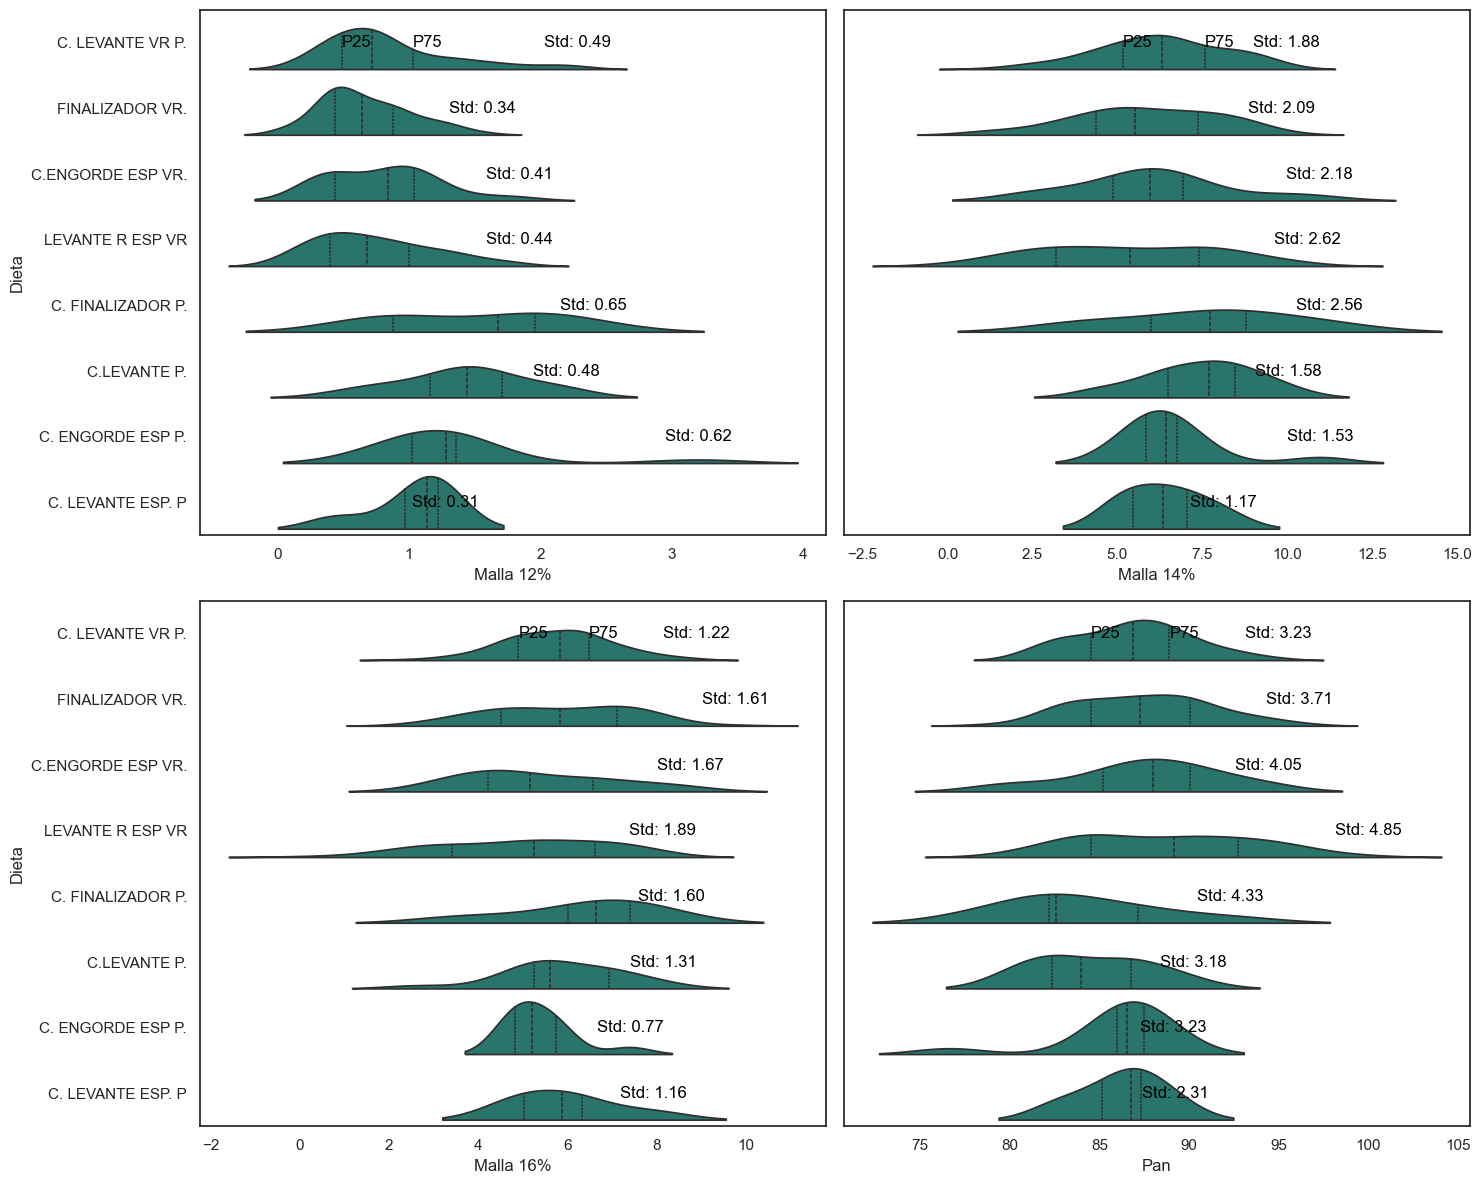

In [ ]:

# Lista de variables y títulos para cada subplot
variables = ["Malla 12%", "Malla 14%", "Malla 16%", "Pan"]
titles = ["Malla 12%", "Malla 14%", "Malla 16%", "Pan"]

# Crear la figura con subplots 2x2 que comparten el eje y
fig, axs = plt.subplots(2, 2, figsize=(15, 12), sharey=True)

# Recorrer cada eje y variable para trazar los gráficos
for ax, var, title in zip(axs.flat, variables, titles):
    # Gráfico de violín
    sns.violinplot(data=df_filter_molienda, y="Dieta", x=var, inner='quartile', split=True,
                   ax=ax, color="#1c8074")
    
    # Calcular y mostrar los percentiles y desviación estándar para cada categoría en 'Dieta'
    categorias = df_filter_molienda["Dieta"].unique()
    yticks = ax.get_yticks()  # Obtener posiciones Y de las etiquetas de Dieta
    
    for i, (categoria, ypos) in enumerate(zip(categorias, yticks)):
        # Obtener datos por categoría
        datos_categoria = df_filter_molienda[df_filter_molienda["Dieta"] == categoria][var].dropna()
        
        # Calcular percentiles
        percentiles = np.percentile(datos_categoria, [25, 75])
        
        # Calcular desviación estándar
        std_dev = np.std(datos_categoria, ddof=1)  # ddof=1 para muestra
        
        # Obtener la mediana
        mediana = np.quantile(datos_categoria, 1)
        
        # Colocar los percentiles en el gráfico
        for p, label in zip(percentiles, ['P25', 'P75']):
            if categoria=='C. LEVANTE VR P.':
                
                ax.text(p, ypos, label, 
                        va='center', 
                        fontsize=12, color='black')
        
        # Mostrar la desviación estándar en la posición de la mediana
        ax.text(mediana, ypos, f"Std: {std_dev:.2f}", 
                fontsize=12, color='black', 
                ha='center', va='center',
                transform=ax.transData,
                #bbox=dict(facecolor='white', alpha=0.6, edgecolor='gray')
                )

    # Etiquetas y títulos
    #ax.set_title(title)
    ax.set_xlabel(var)
    ax.set_ylabel("Dieta")

# Ajustar diseño para evitar superposición
plt.tight_layout()

# Guardar la imagen antes de mostrarla
plt.savefig("../images/granulometria_violin_plots.png", dpi=300)

# Mostrar la imagen en pantalla
plt.show()

# Cerrar la figura para liberar memoria
plt.close()


In [158]:
granularidades = ['Malla 10%', 'Malla 12%', 'Malla 14%', 'Malla 16%', 'Pan']
granulometria_dieta = build_stadistic(
    df=df_filter_molienda,
    metrics=granularidades, 
    group_=["Dieta",], # "Código"
    name_group="Granulometría",  
    name_file="granulometria_dieta")
granulometria_dieta

,Granulometría,Dieta,Media,Cantidad,Mínimo,P25,Mediana,P75,Máximo,Desviación estandar,Varianza,Error estandar
0,Malla 10%,C. ENGORDE ESP P.,0.62,12,0.32,0.46,0.52,0.63,1.80,0.39,0.15,0.11
1,Malla 10%,C. FINALIZADOR P.,0.58,9,0.12,0.24,0.68,0.76,1.30,0.39,0.15,0.13
2,Malla 10%,C. LEVANTE ESP. P,0.40,6,0.24,0.27,0.40,0.53,0.56,0.15,0.02,0.05
3,Malla 10%,C. LEVANTE VR P.,0.23,119,0.04,0.12,0.16,0.28,1.15,0.19,0.04,0.02
4,Malla 10%,C.ENGORDE ESP VR.,0.20,29,0.04,0.12,0.20,0.24,0.52,0.11,0.01,0.02
5,Malla 10%,C.LEVANTE P.,0.55,18,0.12,0.34,0.54,0.64,1.26,0.29,0.08,0.07
6,Malla 10%,FINALIZADOR VR.,0.20,65,0.00,0.12,0.16,0.24,0.54,0.12,0.01,0.01
7,Malla 10%,LEVANTE R ESP VR,0.21,75,0.00,0.12,0.12,0.28,1.16,0.17,0.03,0.02
8,Malla 12%,C. ENGORDE ESP P.,1.35,12,0.80,1.02,1.28,1.36,3.20,0.62,0.39,0.18
9,Malla 12%,C. FINALIZADOR P.,1.50,9,0.60,0.88,1.68,1.96,2.40,0.65,0.43,0.22


In [ ]:
# Lista de variables y títulos para cada subplot
variables = ["Malla 12%", "Malla 14%", "Malla 16%", "Pan"]
titles = ["Malla 12%", "Malla 14%", "Malla 16%", "Pan"]

# Crear la figura con subplots 2x2 que comparten el eje y
fig, axs = plt.subplots(2, 2, figsize=(15, 12), sharey=True)

# Recorrer cada eje y variable para trazar los gráficos
for ax, var, title in zip(axs.flat, variables, titles):
    # Gráfico de violín
    sns.violinplot(data=df_filter_molienda, y="Dieta", x=var, inner='quartile', split=True,
                   ax=ax, color="#1c8074")
    
    # Calcular y mostrar los percentiles y desviación estándar para cada categoría en 'Dieta'
    categorias = df_filter_molienda["Dieta"].unique()
    yticks = ax.get_yticks()  # Obtener posiciones Y de las etiquetas de Dieta
    
    for i, (categoria, ypos) in enumerate(zip(categorias, yticks)):
        # Obtener datos por categoría
        datos_categoria = df_filter_molienda[df_filter_molienda["Dieta"] == categoria][var].dropna()
        
        # Calcular percentiles
        percentiles = np.percentile(datos_categoria, [25, 75])
        
        # Calcular desviación estándar
        std_dev = np.std(datos_categoria, ddof=1)  # ddof=1 para muestra
        
        # Obtener la mediana
        mediana = np.quantile(datos_categoria, 1)
        
        # Colocar los percentiles en el gráfico
        for p, label in zip(percentiles, ['P25', 'P75']):
            if categoria=='C. LEVANTE VR P.':
                
                ax.text(p, ypos, label, 
                        va='center', 
                        fontsize=12, color='black')
        
        # Mostrar la desviación estándar en la posición de la mediana
        ax.text(mediana, ypos, f"Std: {std_dev:.2f}", 
                fontsize=12, color='black', 
                ha='center', va='center',
                transform=ax.transData,
                #bbox=dict(facecolor='white', alpha=0.6, edgecolor='gray')
                )

    # Etiquetas y títulos
    #ax.set_title(title)
    ax.set_xlabel(var)
    ax.set_ylabel("Dieta")

# Ajustar diseño para evitar superposición
plt.tight_layout()

# Guardar la imagen antes de mostrarla
plt.savefig("../images/granulometria_violin_plots.png", dpi=300)

# Mostrar la imagen en pantalla
plt.show()

# Cerrar la figura para liberar memoria
plt.close()


Cantidad
Granulometría Dieta                      
Malla 10%     C. ENGORDE ESP P.        12
              C. FINALIZADOR P.         9
              C. LEVANTE ESP. P         6
              C. LEVANTE VR P.        119
              C.ENGORDE ESP VR.        29
              C.LEVANTE P.             18
              FINALIZADOR VR.          65
              LEVANTE R ESP VR         75
Malla 12%     C. ENGORDE ESP P.        12
              C. FINALIZADOR P.         9
              C. LEVANTE ESP. P         6
              C. LEVANTE VR P.        118
              C.ENGORDE ESP VR.        29
              C.LEVANTE P.             18
              FINALIZADOR VR.          65
              LEVANTE R ESP VR         75
Malla 14%     C. ENGORDE ESP P.        12
              C. FINALIZADOR P.         9
              C. LEVANTE ESP. P         6
              C. LEVANTE VR P.        119
              C.ENGORDE ESP VR.        29
              C.LEVANTE P.             18
              FINALIZADOR VR.          65
              LEVANTE R ESP VR         75
Malla 16%     C. ENGORDE ESP P.        12
              C. FINALIZADOR P.         9
              C. LEVANTE ESP. P         6
              C. LEVANTE VR P.        119
              C.ENGORDE ESP VR.        29
              C.LEVANTE P.             18
              FINALIZADOR VR.          65
              LEVANTE R ESP VR         75
Pan           C. ENGORDE ESP P.        12
              C. FINALIZADOR P.         9
              C. LEVANTE ESP. P         6
              C. LEVANTE VR P.        118
              C.ENGORDE ESP VR.        29
              C.LEVANTE P.             15
              FINALIZADOR VR.          65
              LEVANTE R ESP VR         75

In [290]:
granularidades = ['Malla 10%', 'Malla 12%', 'Malla 14%', 'Malla 16%', 'Pan']
build_stadistic(
    df=df_filter_molienda,
    metrics=granularidades,
    group_=["Dieta"],
    name_group="Granulometría",
    name_file="granulometria_dieta"
    )

,Granulometría,Dieta,Media,Cantidad,Mínimo,P25,Mediana,P75,Máximo,Desviación estandar,Varianza,Error estandar
0,Malla 10%,C. ENGORDE ESP P.,0.62,12,0.32,0.46,0.52,0.63,1.80,0.39,0.15,0.11
1,Malla 10%,C. FINALIZADOR P.,0.58,9,0.12,0.24,0.68,0.76,1.30,0.39,0.15,0.13
2,Malla 10%,C. LEVANTE ESP. P,0.40,6,0.24,0.27,0.40,0.53,0.56,0.15,0.02,0.05
3,Malla 10%,C. LEVANTE VR P.,0.23,119,0.04,0.12,0.16,0.28,1.15,0.19,0.04,0.02
4,Malla 10%,C.ENGORDE ESP VR.,0.20,29,0.04,0.12,0.20,0.24,0.52,0.11,0.01,0.02
5,Malla 10%,C.LEVANTE P.,0.55,18,0.12,0.34,0.54,0.64,1.26,0.29,0.08,0.07
6,Malla 10%,FINALIZADOR VR.,0.20,65,0.00,0.12,0.16,0.24,0.54,0.12,0.01,0.01
7,Malla 10%,LEVANTE R ESP VR,0.21,75,0.00,0.12,0.12,0.28,1.16,0.17,0.03,0.02
8,Malla 12%,C. ENGORDE ESP P.,1.35,12,0.80,1.02,1.28,1.36,3.20,0.62,0.39,0.18
9,Malla 12%,C. FINALIZADOR P.,1.50,9,0.60,0.88,1.68,1.96,2.40,0.65,0.43,0.22


In [299]:
df_filter_pellet.groupby(["Orden producción", "Punto"], as_index=False).agg({"Dureza": "mean"}).head(20)

,Orden producción,Punto,Dureza
0,1.0,POS-ENGRASE,2.563750
1,1.0,ZARANDA 1,3.606667
2,3.0,POS-ENGRASE,3.202500
3,4.0,POS-ENGRASE,2.810000
4,5.0,POS-ENGRASE,2.586000
5,6.0,POS-ENGRASE,3.050000
6,7.0,POS-ENGRASE,2.633333
7,8.0,POS-ENGRASE,3.250000
8,9.0,POS-ENGRASE,2.900000
9,14.0,ZARANDA 1,2.350000


In [ ]:

pellets_measurements = ['Porcentaje Durabilidad']
build_stadistic(
    df=df_filter_pellet,
    metrics=pellets_measurements,
    group_=["Punto", "Dieta"],
    name_group="Tipo medida",
    name_file="porc_durabilidad_punto_dieta"
    ).drop(columns="Tipo medida").sort_values(["Dieta", "Punto"])

,Punto,Dieta,Media,Cantidad,Mínimo,P25,Mediana,P75,Máximo,Desviación estandar,Varianza,Error estandar
4,ZARANDA 1,C. ENGORDE ESP P.,87.93,12,78.8,81.57,90.30,93.10,94.2,6.05,36.62,1.75
5,ZARANDA 1,C. FINALIZADOR P.,91.76,9,90.4,91.60,91.80,92.40,92.6,0.77,0.59,0.26
6,ZARANDA 1,C. LEVANTE ESP. P,90.14,7,87.2,88.10,90.80,91.30,94.2,2.53,6.40,0.96
7,ZARANDA 1,C. LEVANTE VR P.,90.11,149,76.1,89.00,91.00,92.80,95.9,3.77,14.21,0.31
8,ZARANDA 1,C.ENGORDE ESP VR.,89.25,30,78.0,87.78,89.85,91.18,94.4,3.03,9.15,0.55
9,ZARANDA 1,C.LEVANTE P.,92.08,23,83.2,91.90,92.60,93.40,94.4,2.48,6.16,0.52
2,POS-ENGRASE,FINALIZADOR VR.,85.67,21,72.4,80.50,88.00,90.00,94.9,6.24,38.98,1.36
10,ZARANDA 1,FINALIZADOR VR.,90.93,66,85.2,89.28,91.10,92.38,99.8,2.55,6.50,0.31
3,POS-ENGRASE,LEVANTE R ESP VR,87.19,15,72.0,85.55,90.00,91.20,92.8,6.70,44.83,1.73
11,ZARANDA 1,LEVANTE R ESP VR,89.93,58,75.8,88.78,90.60,91.75,98.3,3.33,11.07,0.44


In [314]:
pellets_measurements = ['Dureza']
build_stadistic(
    df=df_filter_pellet,
    metrics=pellets_measurements,
    group_=["Punto", "Dieta"],
    name_group="Tipo medida",
    name_file="porc_dureza_punto_dieta"
    ).drop(columns="Tipo medida").sort_values(["Dieta", "Punto"])

,Punto,Dieta,Media,Cantidad,Mínimo,P25,Mediana,P75,Máximo,Desviación estandar,Varianza,Error estandar
4,ZARANDA 1,C. ENGORDE ESP P.,2.57,12,2.20,2.42,2.53,2.68,3.10,0.25,0.06,0.07
5,ZARANDA 1,C. FINALIZADOR P.,2.76,9,2.29,2.76,2.81,2.90,3.16,0.27,0.07,0.09
6,ZARANDA 1,C. LEVANTE ESP. P,2.36,7,2.12,2.20,2.34,2.45,2.75,0.22,0.05,0.08
7,ZARANDA 1,C. LEVANTE VR P.,2.89,149,1.65,2.50,2.97,3.12,5.40,0.53,0.28,0.04
8,ZARANDA 1,C.ENGORDE ESP VR.,2.70,30,2.01,2.45,2.82,3.00,3.40,0.38,0.14,0.07
9,ZARANDA 1,C.LEVANTE P.,2.90,23,2.20,2.73,3.00,3.15,3.52,0.37,0.13,0.08
2,POS-ENGRASE,FINALIZADOR VR.,2.79,21,1.50,2.33,2.70,3.28,3.96,0.62,0.38,0.13
10,ZARANDA 1,FINALIZADOR VR.,2.92,66,2.10,2.57,2.99,3.29,3.90,0.47,0.22,0.06
3,POS-ENGRASE,LEVANTE R ESP VR,2.80,15,1.60,2.55,3.00,3.20,3.30,0.52,0.27,0.13
11,ZARANDA 1,LEVANTE R ESP VR,2.89,58,1.66,2.60,3.00,3.17,3.80,0.43,0.18,0.06


In [51]:

pellets_measurements = ['TERMOMETRO PLANTA', 'TERMOMETRO AGROINDUSTRIA']
build_stadistic(
    df=temp,
    metrics=pellets_measurements,
    group_=["Punto"],
    name_group="Instrumento",
    name_file="temp_punto"
    )

,Instrumento,Punto,Media,Cantidad,Mínimo,Quantil25,Mediana,Quantil75,Máximo,Desviacion Estandar,Varianza,Error Estandar
0,TERMOMETRO PLANTA,ACONDICIONADOR 1,71.92,63,56.02,71.20,72.31,73.82,80.12,3.65,13.32,0.38
3,TERMOMETRO AGROINDUSTRIA,ACONDICIONADOR 1,71.67,63,54.00,70.30,71.70,74.30,81.50,4.39,19.28,0.46
4,TERMOMETRO AGROINDUSTRIA,ENFRIADORA 1,32.32,63,29.00,31.05,32.30,33.15,39.40,1.99,3.95,0.21
5,TERMOMETRO AGROINDUSTRIA,PELLET 1,82.64,63,70.00,80.60,83.10,84.75,93.30,3.44,11.82,0.36


In [52]:
build_stadistic(
    df=temp,
    metrics=pellets_measurements,
    group_=["Punto", "Dieta"],
    name_group="Instrumento",
    name_file="temp_punto_dieta"
    )

,Instrumento,Punto,Dieta,Media,Cantidad,Mínimo,Quantil25,Mediana,Quantil75,Máximo,Desviacion Estandar,Varianza,Error Estandar
5,TERMOMETRO PLANTA,ACONDICIONADOR 1,FINAL VR,71.65,10,69.34,71.60,71.82,72.21,72.54,0.91,0.83,0.29
7,TERMOMETRO PLANTA,ACONDICIONADOR 1,FINALIZADOR VR.,69.84,6,56.02,70.61,72.48,73.51,74.24,6.92,47.95,2.83
9,TERMOMETRO PLANTA,ACONDICIONADOR 1,LEVANTE ESP VR,71.84,8,62.23,72.47,72.56,73.80,74.85,3.99,15.89,1.41
10,TERMOMETRO PLANTA,ACONDICIONADOR 1,LEVANTE VR,72.12,18,64.06,71.24,72.13,73.39,80.12,3.25,10.59,0.77
38,TERMOMETRO AGROINDUSTRIA,ACONDICIONADOR 1,FINAL VR,70.75,10,54.00,71.10,71.30,72.20,81.50,6.71,44.97,2.12
40,TERMOMETRO AGROINDUSTRIA,ACONDICIONADOR 1,FINALIZADOR VR.,71.10,6,64.80,70.28,71.10,73.28,75.60,3.71,13.75,1.51
42,TERMOMETRO AGROINDUSTRIA,ACONDICIONADOR 1,LEVANTE ESP VR,70.25,8,62.00,69.85,71.95,72.40,73.90,4.00,15.99,1.41
43,TERMOMETRO AGROINDUSTRIA,ACONDICIONADOR 1,LEVANTE VR,72.09,18,64.10,70.22,71.80,75.10,80.40,4.06,16.45,0.96
49,TERMOMETRO AGROINDUSTRIA,ENFRIADORA 1,FINAL VR,31.17,10,29.10,30.32,30.95,32.15,33.50,1.38,1.91,0.44
51,TERMOMETRO AGROINDUSTRIA,ENFRIADORA 1,FINALIZADOR VR.,34.97,6,32.90,34.20,34.40,34.83,39.00,2.09,4.37,0.85


In [53]:

pellets_measurements = ['TERMOMETRO PLANTA', 'TERMOMETRO AGROINDUSTRIA']
build_stadistic(
    df=temp,
    metrics=pellets_measurements,
    group_=["Orden producción", "Dieta"],
    name_group="Instrumento",
    name_file="temp_op"
    )

,Instrumento,Orden producción,Dieta,Media,Cantidad,Mínimo,Quantil25,Mediana,Quantil75,Máximo,Desviacion Estandar,Varianza,Error Estandar
0,TERMOMETRO PLANTA,1.0,FINALIZADOR VR.,69.84,6,56.02,70.61,72.48,73.51,74.24,6.92,47.95,1.63
34,TERMOMETRO AGROINDUSTRIA,1.0,FINALIZADOR VR.,62.56,18,32.90,35.92,71.10,79.58,84.50,20.77,431.20,4.89
35,TERMOMETRO AGROINDUSTRIA,1.0,LEVANTE VR,65.58,6,29.80,42.05,75.25,85.50,93.30,27.70,767.44,11.31
37,TERMOMETRO AGROINDUSTRIA,17.0,C.LEVANTE VR,65.64,6,33.03,43.66,76.80,84.66,87.30,25.66,658.43,10.48
40,TERMOMETRO AGROINDUSTRIA,33.0,C.FINALIZACION VR,62.00,6,32.00,42.88,71.10,78.18,83.80,23.22,539.08,9.48
50,TERMOMETRO AGROINDUSTRIA,77.0,ENGORDE ESP VR,63.77,6,30.00,43.15,74.75,80.85,87.60,25.60,655.40,10.45
55,TERMOMETRO AGROINDUSTRIA,94.0,LEVANTE VR,62.37,9,32.50,33.10,75.50,77.20,82.80,22.53,507.67,7.51
56,TERMOMETRO AGROINDUSTRIA,95.0,FINAL VR,58.98,9,29.70,32.00,71.10,79.10,81.50,22.56,508.99,7.52
57,TERMOMETRO AGROINDUSTRIA,97.0,LEVANTE ESP VR,62.65,6,31.90,43.25,72.30,79.60,83.80,23.65,559.50,9.66
58,TERMOMETRO AGROINDUSTRIA,100.0,FINAL VR,60.32,6,30.30,41.92,71.25,76.12,79.20,22.76,517.89,9.29


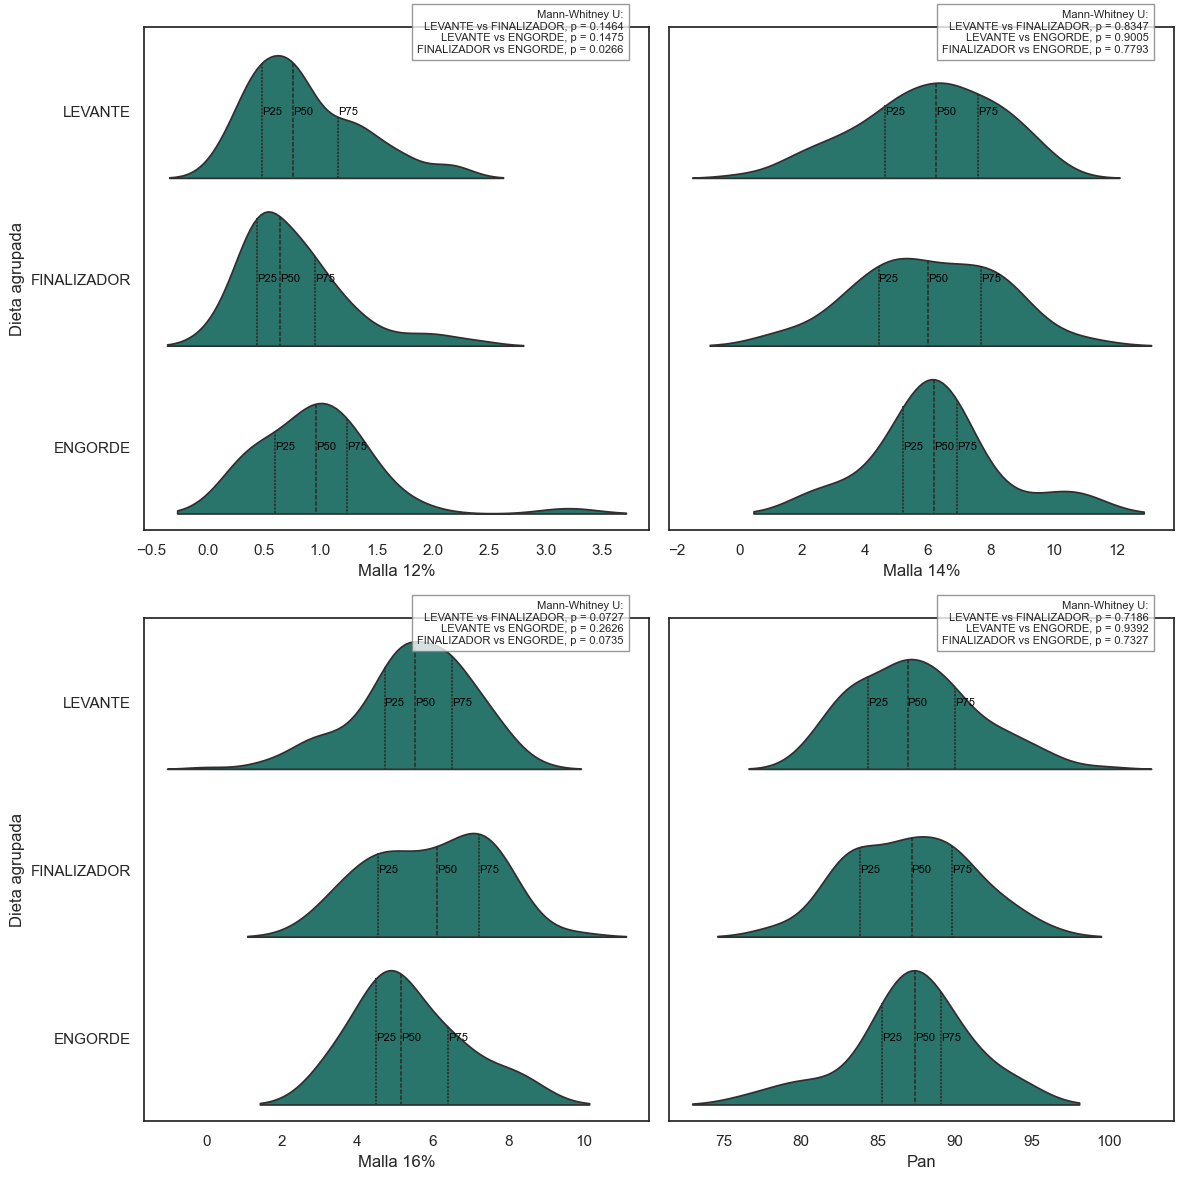

In [207]:


# Lista de variables y títulos para cada subplot
variables = ["Malla 12%", "Malla 14%", "Malla 16%", "Pan"]
titles = ["Malla 12%", "Malla 14%", "Malla 16%", "Pan"]

# Crear la figura con subplots 2x2 que comparten el eje y
fig, axs = plt.subplots(2, 2, figsize=(12, 12), sharey=True)

# Recorrer cada eje y variable para trazar los gráficos
for ax, var, title in zip(axs.flat, variables, titles):
    # Gráfico de violín
    sns.violinplot(data=df_filter_molienda, y="Dieta agrupada", x=var, inner='quartile', split=True,
                   ax=ax, color="#1c8074")
    
    # Calcular y mostrar los percentiles para cada categoría en 'Dieta agrupada'
    categorias = df_filter_molienda["Dieta agrupada"].unique()
    for i, categoria in enumerate(categorias):
        # Obtener datos por categoría
        datos_categoria = df_filter_molienda[df_filter_molienda["Dieta agrupada"] == categoria][var].dropna()
        
        # Calcular percentiles
        percentiles = np.percentile(datos_categoria, [25, 50, 75])
        
        # Colocar los nombres en una posición personalizada (esquina superior derecha)
        for p, label in zip(percentiles, ['P25', 'P50', 'P75']):
            ax.text(p, i, label, 
                    ha='left', va='center', 
                    fontsize=8, color='black',
                    #bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray')
                    )
    
    # Etiquetas y títulos
    ax.set_ylabel("Dieta agrupada")
    #ax.set_title(title)
    
    # Realizar la prueba de Mann-Whitney U para cada par de productos
    productos = df_filter_molienda["Dieta agrupada"].unique()
    resultados = []
    
    # Comparar todos los pares de productos
    for prod1, prod2 in combinations(productos, 2):
        grupo1 = df_filter_molienda[df_filter_molienda["Dieta agrupada"] == prod1][var].dropna()
        grupo2 = df_filter_molienda[df_filter_molienda["Dieta agrupada"] == prod2][var].dropna()
        
        # Realizar la prueba de Mann-Whitney U
        u_stat, p_value = stats.mannwhitneyu(grupo1, grupo2, alternative='two-sided')
        resultados.append(f"{prod1} vs {prod2}, p = {p_value:.4f}")
    
    # Agregar los resultados de la prueba como texto en el gráfico
    test_result = "Mann-Whitney U:\n" + "\n".join(resultados)
    ax.text(0.95, 0.95, test_result, transform=ax.transAxes, fontsize=8,
            verticalalignment='baseline', horizontalalignment='right',
            bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray')
            )

# Ajuste del layout
plt.tight_layout()

# Guardar la imagen antes de mostrarla
plt.savefig("../images/granulometria_violin_plots.png", dpi=300)

# Mostrar la imagen en pantalla
plt.show()

# Cerrar la figura para liberar memoria
plt.close()


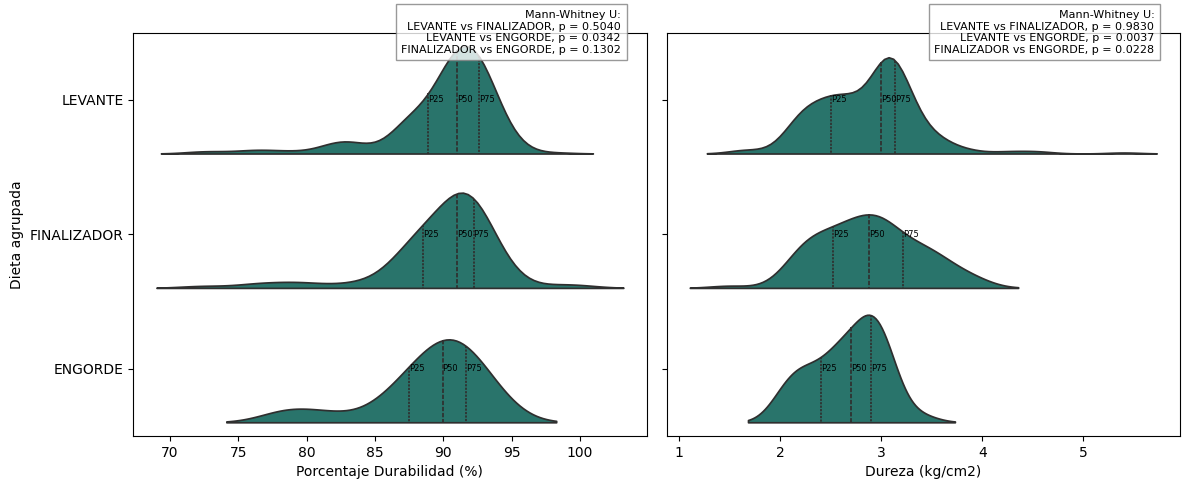

In [57]:


# Lista de variables y títulos para cada subplot
variables = ['Porcentaje Durabilidad', 'Dureza']
titles = ['Porcentaje Durabilidad', 'Dureza']

# Crear la figura con subplots 1x2 que comparten el eje y
fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# Recorrer cada eje y variable para trazar los gráficos
for ax, var, title in zip(axs.flat, variables, titles):
    # Gráfico de violín
    sns.violinplot(data=df_filter_pellet, y='Dieta agrupada', x=var, inner='quartile', split=True,
                   ax=ax, color="#1c8074")
    
    # Calcular y mostrar los percentiles para cada categoría en 'Dieta agrupada'
    categorias = df_filter_pellet["Dieta agrupada"].unique()
    for i, categoria in enumerate(categorias):
        # Obtener datos por categoría
        datos_categoria = df_filter_pellet[df_filter_pellet["Dieta agrupada"] == categoria][var].dropna()
        
        # Calcular percentiles
        percentiles = np.percentile(datos_categoria, [25, 50, 75])
        
        # Colocar los nombres en una posición personalizada (esquina superior derecha)
        for p, label in zip(percentiles, ['P25', 'P50', 'P75']):
            ax.text(p, i, label, 
                    ha='left', va='center', 
                    fontsize=6, color='black',
                    #bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray')
                    )
    
    # Etiquetas de los ejes
    uni = '(%)' if var == "Porcentaje Durabilidad" else "(kg/cm2)"
    ax.set_xlabel(f'{var} {uni}')
    ax.set_ylabel("Dieta agrupada")
    #ax.set_title(title)
    
    # Realizar la prueba de Mann-Whitney U para cada par de productos
    productos = df_filter_pellet['Dieta agrupada'].unique()
    resultados = []
    
    # Comparar todos los pares de productos
    for prod1, prod2 in combinations(productos, 2):
        grupo1 = df_filter_pellet[df_filter_pellet['Dieta agrupada'] == prod1][var].dropna()
        grupo2 = df_filter_pellet[df_filter_pellet['Dieta agrupada'] == prod2][var].dropna()
        
        # Realizar la prueba de Mann-Whitney U
        u_stat, p_value = stats.mannwhitneyu(grupo1, grupo2, alternative='two-sided')
        resultados.append(f"{prod1} vs {prod2}, p = {p_value:.4f}")
    
    # Agregar los resultados de la prueba como texto en el gráfico
    test_result = "Mann-Whitney U:\n" + "\n".join(resultados)
    ax.text(0.95, 0.95, test_result, transform=ax.transAxes, fontsize=8,
            verticalalignment='baseline', horizontalalignment='right',
            bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray'))

# Ajuste del layout
plt.tight_layout()

# Guardar la imagen antes de mostrarla
plt.savefig("../images/durabilidad_dureza_violin_plots.png", dpi=300)

# Mostrar la imagen en pantalla
plt.show()

# Cerrar la figura para liberar memoria
plt.close()
